In [31]:
!pip install transformers datasets

In [32]:
import os
import re
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Define repository name for output
repo_name = "./results/finetuned-financialbert"

# Load the zeroshot/twitter-financial-news-sentiment dataset
print("Loading dataset...")
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Print dataset structure
print("Dataset structure:")
print(dataset)

# Print first few examples as raw data
print("\nRaw examples from training set:")
for i, example in enumerate(dataset["train"][:5]):
    print(f"Example {i}: {example}")

# Check if the examples are dictionaries with expected keys
if not all(key in dataset["train"].features for key in ["text", "label"]):
    raise ValueError("Dataset does not contain expected 'text' and 'label' keys.")

# Preprocessing function for tweets
def preprocess_tweet(text):
    if not isinstance(text, str):
        return ""
    # Replace URLs with [URL] token
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    # Remove # symbol from hashtags
    text = re.sub(r'#', '', text)
    # Remove repeated punctuations (keep only one instance)
    text = re.sub(r'([!?.])\1+', r'\1', text)
    return text.strip()

# Apply preprocessing to the dataset
def preprocess_dataset(example):
    example["text"] = preprocess_tweet(example["text"])
    return example

dataset = dataset.map(preprocess_dataset)

# Map labels to ensure consistency (assuming labels are 0, 1, 2 for Bearish, Neutral, Bullish)
def map_labels(example):
    if isinstance(example["label"], str):
        label_mapping = {"Bearish": 0, "Neutral": 1, "Bullish": 2}
        example["labels"] = label_mapping.get(example["label"], 1)  # Default to Neutral (1) if unknown
    else:
        example["labels"] = example["label"]
    return example

dataset = dataset.map(map_labels)

# Take 1/10th of the dataset for fine-tuning
def sample_dataset(dataset, fraction=0.1, seed=42):
    np.random.seed(seed)
    sampled_dataset = DatasetDict()
    for split in dataset.keys():
        num_samples = max(1, int(len(dataset[split]) * fraction))
        indices = np.random.choice(
            range(len(dataset[split])),
            size=num_samples,
            replace=False
        )
        sampled_dataset[split] = dataset[split].select(indices)
    return sampled_dataset

sampled_dataset = dataset  # Use full dataset for fine-tuning

print("\nFinal dataset structure:")
for split in sampled_dataset:
    print(f"{split}: {len(sampled_dataset[split])} examples")

print("\nFirst example in training set:")
print(sampled_dataset["train"][0])

# Load the tokenizer and model
model_name = "ahmedrachid/FinancialBERT-Sentiment-Analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenize the dataset
tokenized_dataset = sampled_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=[col for col in sampled_dataset["train"].column_names if col != "labels"]
)

# Define metrics computation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Argmax to select the class with highest probability
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=2,  # As specified
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Fine-tune the model
print("Starting fine-tuning...")
trainer.train()



# Save the model and tokenizer
model_save_path = "./final-model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Loading dataset...
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

Raw examples from training set:
Example 0: text
Example 1: label

Final dataset structure:
train: 9543 examples
validation: 2388 examples

First example in training set:
{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat [URL]', 'label': 0, 'labels': 0}


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.542800,0.509215,0.811139,0.812340,0.815653,0.811139
2,0.375500,0.434985,0.845059,0.841532,0.841325,0.845059


Model saved to ./final-model


In [33]:
# Evaluate the model on the test set
final_results = trainer.evaluate(tokenized_dataset["validation"])
print(f"Final test results: {final_results}")

Final test results: {'eval_loss': 0.4349846839904785, 'eval_accuracy': 0.8450586264656617, 'eval_f1': 0.8415319090847064, 'eval_precision': 0.8413249544549752, 'eval_recall': 0.8450586264656617, 'eval_runtime': 17.3486, 'eval_samples_per_second': 137.648, 'eval_steps_per_second': 8.646, 'epoch': 2.0}


# AAPL

In [34]:
from datetime import datetime
import torch

# Load the fine-tuned FinancialBERT model and tokenizer
model_path = "./final-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the datasets
stock_index_df = pd.read_csv("stock_index.csv")
posts_df = pd.read_csv("posts.csv")

# Filter for AAPL stock
stock_index_aapl = stock_index_df[stock_index_df["stock_symbol"] == "aapl"].copy()

# Convert created_utc to datetime for merging
stock_index_aapl["created_utc"] = pd.to_datetime(stock_index_aapl["created_utc"], unit="s")
posts_df["created_utc"] = pd.to_datetime(posts_df["created_utc"], unit="s")

# Merge datasets on 'id' and 'created_utc'
combined_df = pd.merge(stock_index_aapl, posts_df, on=["id", "created_utc"], how="inner")

# Drop rows where selftext or title is null/removed
combined_df = combined_df[
    (combined_df["selftext"] != "[null]") &
    (combined_df["selftext"] != "[removed]") &
    (combined_df["title"] != "[null]") &
    (combined_df["title"] != "[removed]")
]

# Preprocessing function for tweets/posts
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Replace URLs with [URL] token
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    # Remove # symbol from hashtags
    text = re.sub(r'#', '', text)
    # Remove repeated punctuations
    text = re.sub(r'([!?.])\1+', r'\1', text)
    return text.strip()

# Apply preprocessing to title and selftext
combined_df["processed_title"] = combined_df["title"].apply(preprocess_text)
combined_df["processed_selftext"] = combined_df["selftext"].apply(preprocess_text)

# Combine title and selftext for sentiment analysis
combined_df["combined_text"] = combined_df["processed_title"] + " " + combined_df["processed_selftext"]

# Replace the sentiment scoring section with batched processing
def get_sentiment_scores_batched(texts):
    if not texts or all(not isinstance(t, str) for t in texts):
        return np.zeros(len(texts))

    # Tokenize in batches
    inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

    # Map probabilities to sentiment scores
    sentiment_scores = -1 * probabilities[:, 0] + 0 * probabilities[:, 1] + 1 * probabilities[:, 2]
    return sentiment_scores

# Apply batched sentiment scoring
batch_size = 32
print("Calculating sentiment scores in batches...")
sentiment_scores = []
for i in range(0, len(combined_df), batch_size):
    batch_texts = combined_df["combined_text"][i:i + batch_size].tolist()
    batch_scores = get_sentiment_scores_batched(batch_texts)
    sentiment_scores.extend(batch_scores)

combined_df["sentiment_score"] = sentiment_scores

# Aggregate by day
combined_df["date_only"] = combined_df["created_utc"].dt.date
daily_sentiment = combined_df.groupby("date_only").agg({
    "sentiment_score": "mean",  # Average sentiment score per day
    "id": "count"              # Number of posts per day
}).rename(columns={"id": "post_count"}).reset_index()

daily_sentiment["normalized_post_count"] = daily_sentiment["post_count"] / daily_sentiment["post_count"].sum()
daily_sentiment["weighted_sentiment_score"] = daily_sentiment["normalized_post_count"] * daily_sentiment["sentiment_score"]

# Display results
print("\nDaily Sentiment Analysis for AAPL:")
print(daily_sentiment)

# Save the results
output_file = "aapl_sentiment_analysis.csv"
daily_sentiment.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


<ipython-input-34-21f7fe09aa19>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["processed_title"] = combined_df["title"].apply(preprocess_text)


Calculating sentiment scores in batches...

Daily Sentiment Analysis for AAPL:
       date_only  sentiment_score  post_count  normalized_post_count  \
0     2018-01-01         0.823541           8               0.000223   
1     2018-01-02         0.744317          15               0.000419   
2     2018-01-03         0.824230          11               0.000307   
3     2018-01-04         0.840020           8               0.000223   
4     2018-01-05         0.796873          13               0.000363   
...          ...              ...         ...                    ...   
1805  2022-12-27         0.542791          23               0.000642   
1806  2022-12-28         0.460309          41               0.001144   
1807  2022-12-29         0.518420          38               0.001061   
1808  2022-12-30         0.596759          19               0.000530   
1809  2022-12-31         0.398770          20               0.000558   

      weighted_sentiment_score  
0                     0

In [35]:
!pip install praw

In [ ]:
from datetime import timedelta
import praw

# Setup Reddit API with PRAW
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent='Stock Sentiment Analysis Script'
)

# Define subreddits and ticker
subreddits = ["AAPL", "applestocks", "stocks", "wallstreetbets"]
ticker = "AAPL"
company_name = "Apple"

# Define timeframe: last 12 months
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=540)

# Function to fetch Reddit posts using PRAW
def fetch_reddit_posts(subreddit, limit=2000):
    posts = []
    for post in reddit.subreddit(subreddit).new(limit=limit):
        post_time = datetime.utcfromtimestamp(post.created_utc)

        # Filter posts by timeframe
        if start_time <= post_time <= end_time:
            posts.append({
                "id": post.id,
                "title": post.title,
                "selftext": post.selftext,
                "created_utc": post_time
            })

    return pd.DataFrame(posts)

# Fetch posts from all subreddits
all_posts = []
for sub in subreddits:
    df = fetch_reddit_posts(sub)
    all_posts.append(df)

    if sub == "AAPL" or sub == "applestocks":
        # Keep all posts from AAPL subreddit
        all_posts.append(df)
    else:
        # Keep only posts mentioning "AAPL" or "Apple"
        df_filtered = df[
            df["title"].str.contains(r'\b(AAPL|Apple)\b', case=False, na=False) |
            df["selftext"].str.contains(r'\b(AAPL|Apple)\b', case=False, na=False)
        ]
        all_posts.append(df_filtered)

# Combine all data
reddit_df = pd.concat(all_posts, ignore_index=True)
print(f"Total posts collected: {len(reddit_df)}")

# Preprocessing function for text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    text = re.sub(r'#', '', text)
    text = re.sub(r'([!?.])\1+', r'\1', text)
    return text.strip()

# Apply preprocessing
reddit_df["processed_title"] = reddit_df["title"].apply(preprocess_text)
reddit_df["processed_selftext"] = reddit_df["selftext"].apply(preprocess_text)
reddit_df["combined_text"] = reddit_df["processed_title"] + " " + reddit_df["processed_selftext"]

# Load fine-tuned sentiment model
model_path = "./final-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to get sentiment scores in batches
def get_sentiment_scores_batched(texts, batch_size=32):
    sentiment_scores = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size].tolist()
        inputs = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

        # Convert probabilities to sentiment score (-1 for bearish, 0 neutral, 1 bullish)
        batch_scores = -1 * probabilities[:, 0] + 0 * probabilities[:, 1] + 1 * probabilities[:, 2]
        sentiment_scores.extend(batch_scores)

    return sentiment_scores

# Compute sentiment scores
reddit_df["sentiment_score"] = get_sentiment_scores_batched(reddit_df["combined_text"])

# Aggregate by day
reddit_df["date_only"] = reddit_df["created_utc"].dt.date
daily_sentiment = reddit_df.groupby("date_only").agg({
    "sentiment_score": "mean",
    "id": "count"
}).rename(columns={"id": "post_count"}).reset_index()

# Normalize post count
daily_sentiment["normalized_post_count"] = daily_sentiment["post_count"] / daily_sentiment["post_count"].sum()
daily_sentiment["weighted_sentiment_score"] = daily_sentiment["normalized_post_count"] * daily_sentiment["sentiment_score"]

# Save results
output_file = "aapl_sentiment_analysis.csv"
daily_sentiment.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Display the first few rows
data = pd.read_csv(output_file)
print(data.head())


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Total posts collected: 2964
Results saved to aapl_sentiment_analysis.csv
    date_only  sentiment_score  post_count  normalized_post_count  \
0  2023-09-20         0.985007           2               0.000675   
1  2023-09-24        -0.991249           2               0.000675   
2  2023-09-27         0.977699           2               0.000675   
3  2023-10-03         0.845619           6               0.002024   
4  2023-10-04         0.869661           2               0.000675   

   weighted_sentiment_score  
0                  0.000665  
1                 -0.000669  
2                  0.000660  
3                  0.001712  
4                  0.000587  


In [37]:
!pip install yfinance -U

In [38]:
import yfinance as yf

# Load Reddit sentiment data
reddit_sentiment = pd.read_csv("aapl_sentiment_analysis.csv")
reddit_sentiment["date_only"] = pd.to_datetime(reddit_sentiment["date_only"])

# Fetch historical AAPL stock prices
start_date = "2023-09-20"
end_date = pd.to_datetime("today").strftime("%Y-%m-%d")
aapl = yf.download("AAPL", start=start_date, end=end_date, auto_adjust=False)

# Flatten MultiIndex
if isinstance(aapl.columns, pd.MultiIndex):
    aapl.columns = aapl.columns.get_level_values(0)

# Reset index and rename columns properly
aapl = aapl.reset_index()
aapl = aapl.rename(columns={"Date": "date_only", "Adj Close": "adj_close"})

# Ensure `date_only` is in datetime format
aapl["date_only"] = pd.to_datetime(aapl["date_only"])
reddit_sentiment["date_only"] = pd.to_datetime(reddit_sentiment["date_only"])

# Ensure single-level index before merging
reddit_sentiment = reddit_sentiment.set_index("date_only").reset_index()
aapl = aapl.set_index("date_only").reset_index()

# Merge with sentiment data
data = pd.merge(reddit_sentiment, aapl[["date_only", "adj_close"]], on="date_only", how="inner")

# Generate lag features
data["lag_1"] = data["adj_close"].shift(1)
data["lag_2"] = data["adj_close"].shift(2)
data["lag_3"] = data["adj_close"].shift(3)

# Generate moving average features
data["ma_5"] = data["adj_close"].rolling(window=5).mean()
data["ma_10"] = data["adj_close"].rolling(window=10).mean()

# Create stock price transformations as features
data["daily_return"] = data["adj_close"].pct_change()
data["log_return"] = np.log(data["adj_close"] / data["adj_close"].shift(1))

# Drop rows with NaN values
data = data.dropna()

# Save processed data
processed_file = "aapl_stock_sentiment_features.csv"
data.to_csv(processed_file, index=False)
print(f"Processed data saved to {processed_file}")

# Display the first few rows
data = pd.read_csv(processed_file)
print(data.head())



[*********************100%***********************]  1 of 1 completed

Processed data saved to aapl_stock_sentiment_features.csv
    date_only  sentiment_score  post_count  normalized_post_count  \
0  2023-11-06         0.755774           4               0.001350   
1  2023-11-13         0.903892           2               0.000675   
2  2023-11-16         0.439392           2               0.000675   
3  2023-11-17         0.974875           2               0.000675   
4  2023-11-21         0.117351           2               0.000675   

   weighted_sentiment_score   adj_close       lag_1       lag_2       lag_3  \
0                  0.001020  177.925919  175.364716  176.278000  169.050964   
1                  0.000610  183.697098  177.925919  175.364716  176.278000   
2                  0.000296  188.577820  183.697098  177.925919  175.364716   
3                  0.000658  188.557907  188.577820  183.697098  177.925919   
4                  0.000079  189.502243  188.557907  188.577820  183.697098   

         ma_5       ma_10  daily_return  log_return 

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2177 - val_loss: 0.1968
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0819 - val_loss: 0.0090
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0451 - val_loss: 0.0229
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0241 - val_loss: 0.0129
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0184 - val_loss: 0.0069
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0275 - val_loss: 0.0176
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0174 - val_loss: 0.0097
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0177 - val_loss: 0.0075
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0179 - val_loss: 0.0202
Epoch 10/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0155 - val_loss: 0.0056
Epoch 11/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0137 - val_loss: 0.0055
Epoch 12/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0173 - val_loss: 0.0199
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 712ms/step - loss: 0.1524 - val_loss: 0.5207
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1205 - val_loss: 0.4020
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0805 - val_loss: 0.1945
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0389 - val_loss: 0.0284
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0341 - val_loss: 0.1009
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0743
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0214 - val_loss: 0.0213
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0193 - val_loss: 0.0188
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0104 - val_loss: 0.0051
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092 - val_loss: 0.0077

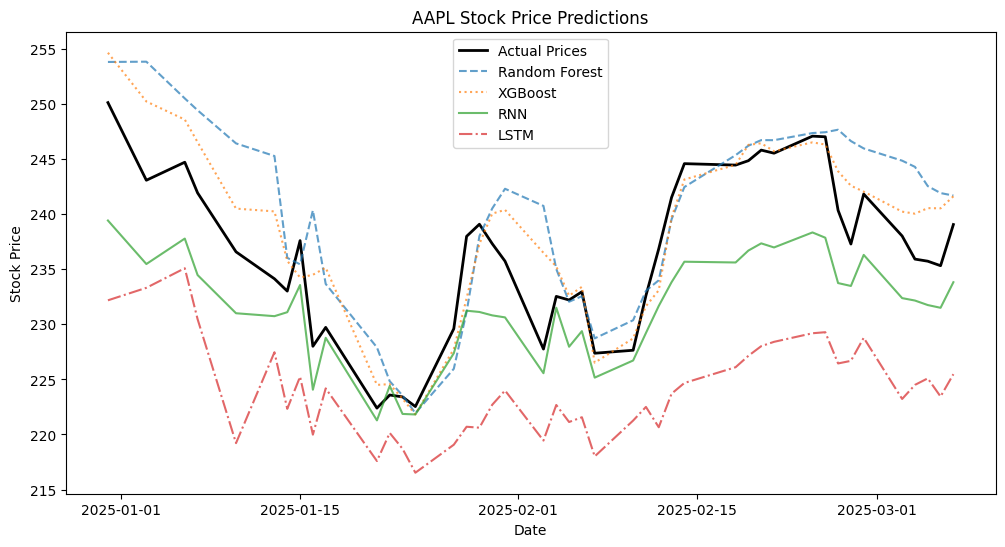

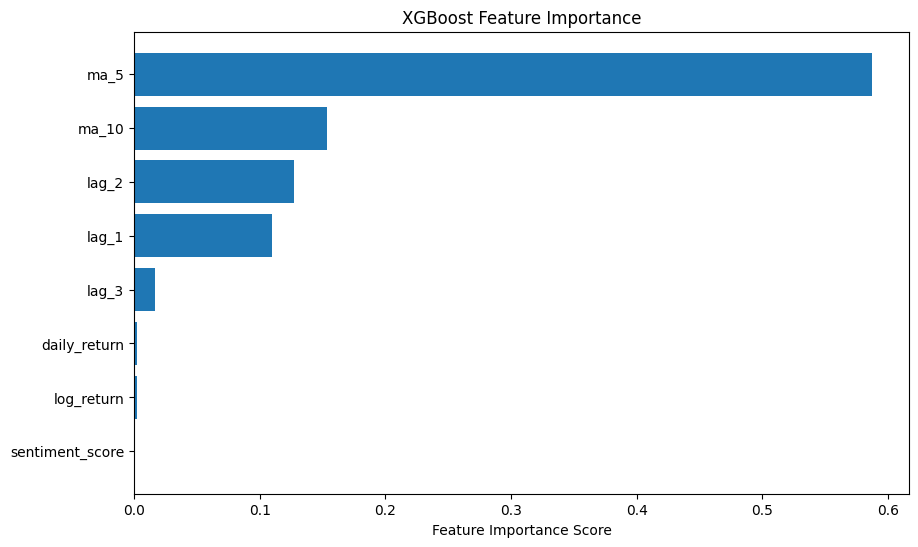

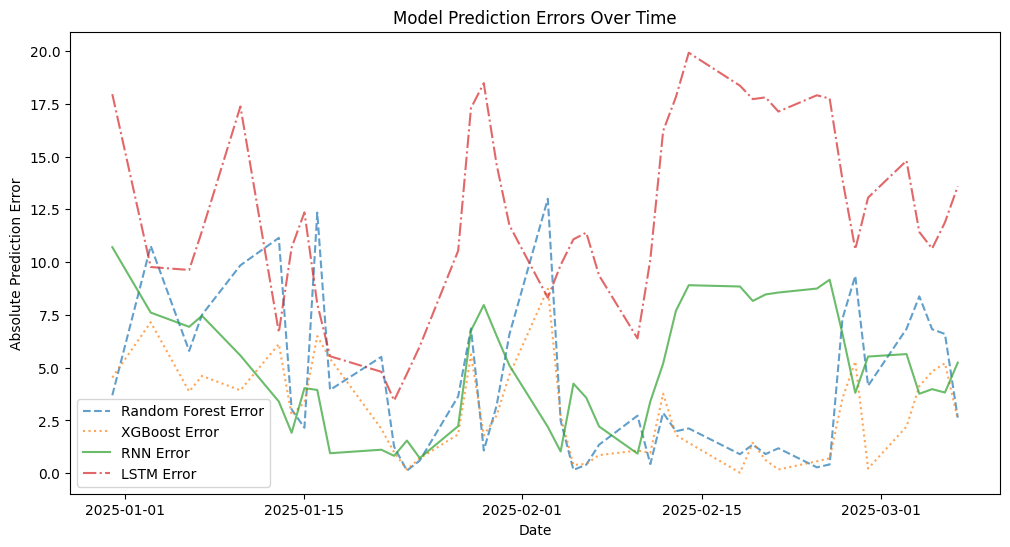

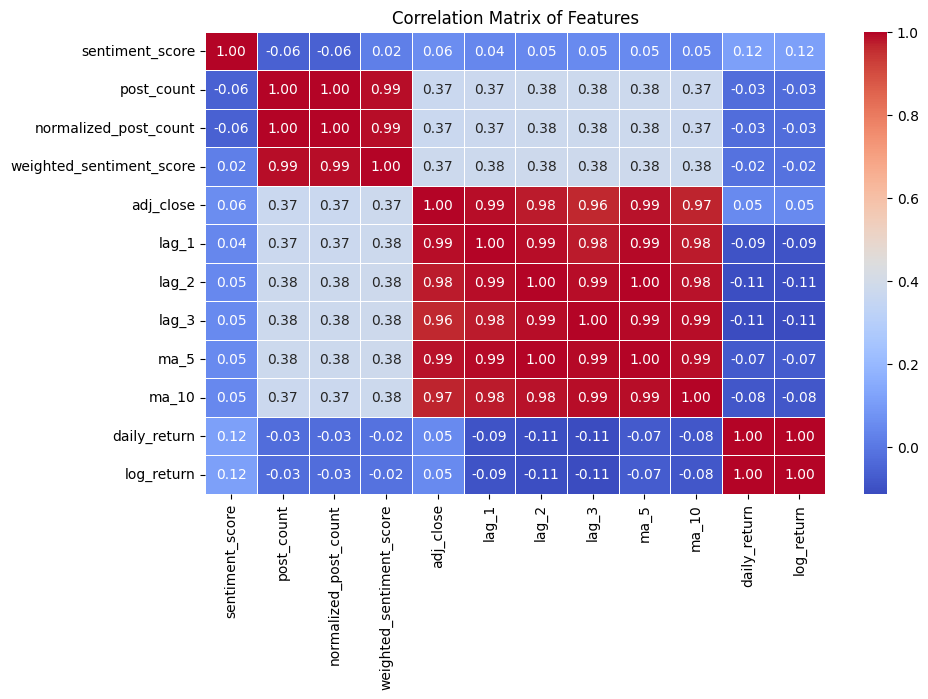

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load processed dataset
data = pd.read_csv("aapl_stock_sentiment_features.csv")
data["date_only"] = pd.to_datetime(data["date_only"])
data.set_index("date_only", inplace=True)

# Define Features and Target
features = ["sentiment_score", "lag_1", "lag_2", "lag_3", "ma_5", "ma_10", "daily_return", "log_return"]
X = data[features]
y = data["adj_close"]

# Train-Test Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature Scaling
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Target Scaling
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Reshape for RNN models
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Random Forest Model
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=4, min_samples_leaf=2, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)
rf_preds_scaled = rf.predict(X_test_scaled)
rf_preds = target_scaler.inverse_transform(rf_preds_scaled.reshape(-1, 1)).flatten()

# XGBoost Model
xgb = XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train_scaled, y_train_scaled)
xgb_preds_scaled = xgb.predict(X_test_scaled)
xgb_preds = target_scaler.inverse_transform(xgb_preds_scaled.reshape(-1, 1)).flatten()

# RNN Model
rnn_model = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.3),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rnn_model.fit(
    X_train_rnn, y_train_scaled,
    epochs=150,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)
rnn_preds_scaled = rnn_model.predict(X_test_rnn).flatten()
rnn_preds = target_scaler.inverse_transform(rnn_preds_scaled.reshape(-1, 1)).flatten()

# LSTM Model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

lstm_model.fit(
    X_train_rnn, y_train_scaled,
    epochs=200,
    batch_size=16,
    verbose=1,
    validation_split=0.2
)
lstm_preds_scaled = lstm_model.predict(X_test_rnn).flatten()
lstm_preds = target_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# Evaluate all Models
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f" {name} Performance:")
    print(f"   MAE: {mae:.4f}")
    print(f"   MSE: {mse:.4f}")
    print(f"   R² Score: {r2:.4f}")
    print("-" * 40)
    return mae, mse, r2

rf_metrics = evaluate_model("Random Forest", y_test, rf_preds)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_preds)
rnn_metrics = evaluate_model("RNN", y_test, rnn_preds)
lstm_metrics = evaluate_model("LSTM", y_test, lstm_preds)

# Plot Model Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Prices", color="black", linewidth=2)
plt.plot(y_test.index, rf_preds, label="Random Forest", linestyle="dashed", alpha=0.7)
plt.plot(y_test.index, xgb_preds, label="XGBoost", linestyle="dotted", alpha=0.7)
plt.plot(y_test.index, rnn_preds, label="RNN", linestyle="solid", alpha=0.7)
plt.plot(y_test.index, lstm_preds, label="LSTM", linestyle="dashdot", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("AAPL Stock Price Predictions")
plt.legend()
plt.show()

# Get feature importances from XGBoost
importances = xgb.feature_importances_
feature_names = X.columns

# Sort feature importances
sorted_idx = np.argsort(importances)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# Compute Absolute Prediction Errors
rf_errors = np.abs(y_test - rf_preds)
xgb_errors = np.abs(y_test - xgb_preds)
rnn_errors = np.abs(y_test - rnn_preds)
lstm_errors = np.abs(y_test - lstm_preds)

# Plot Prediction Errors Over Time
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, rf_errors, label="Random Forest Error", linestyle="dashed", alpha=0.7)
plt.plot(y_test.index, xgb_errors, label="XGBoost Error", linestyle="dotted", alpha=0.7)
plt.plot(y_test.index, rnn_errors, label="RNN Error", linestyle="solid", alpha=0.7)
plt.plot(y_test.index, lstm_errors, label="LSTM Error", linestyle="dashdot", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Absolute Prediction Error")
plt.title("Model Prediction Errors Over Time")
plt.legend()
plt.show()

# Compute Correlation Matrix
correlation_matrix = data.corr()

# Plot Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# NVDA

In [40]:
import pandas as pd
import numpy as np
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re

# Load the fine-tuned FinancialBERT model and tokenizer
model_path = "./final-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the datasets
stock_index_df = pd.read_csv("stock_index.csv")
posts_df = pd.read_csv("posts.csv")

# Filter for NVDA stock
stock_index_nvda = stock_index_df[stock_index_df["stock_symbol"] == "nvda"].copy()

# Convert created_utc to datetime for merging
stock_index_nvda["created_utc"] = pd.to_datetime(stock_index_nvda["created_utc"], unit="s")
posts_df["created_utc"] = pd.to_datetime(posts_df["created_utc"], unit="s")

# Merge datasets on 'id' and 'created_utc'
combined_df = pd.merge(stock_index_nvda, posts_df, on=["id", "created_utc"], how="inner")

# Drop rows where selftext or title is null/removed
combined_df = combined_df[
    (combined_df["selftext"] != "[null]") &
    (combined_df["selftext"] != "[removed]") &
    (combined_df["title"] != "[null]") &
    (combined_df["title"] != "[removed]")
]

# Preprocessing function for tweets/posts
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Replace URLs with [URL] token
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    # Remove # symbol from hashtags
    text = re.sub(r'#', '', text)
    # Remove repeated punctuations
    text = re.sub(r'([!?.])\1+', r'\1', text)
    return text.strip()

# Apply preprocessing to title and selftext
combined_df["processed_title"] = combined_df["title"].apply(preprocess_text)
combined_df["processed_selftext"] = combined_df["selftext"].apply(preprocess_text)

# Combine title and selftext for sentiment analysis
combined_df["combined_text"] = combined_df["processed_title"] + " " + combined_df["processed_selftext"]

# Replace the sentiment scoring section with batched processing
def get_sentiment_scores_batched(texts):
    if not texts or all(not isinstance(t, str) for t in texts):
        return np.zeros(len(texts))

    # Tokenize in batches
    inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

    # Map probabilities to sentiment scores
    sentiment_scores = -1 * probabilities[:, 0] + 0 * probabilities[:, 1] + 1 * probabilities[:, 2]
    return sentiment_scores

# Apply batched sentiment scoring
batch_size = 32
print("Calculating sentiment scores in batches...")
sentiment_scores = []
for i in range(0, len(combined_df), batch_size):
    batch_texts = combined_df["combined_text"][i:i + batch_size].tolist()
    batch_scores = get_sentiment_scores_batched(batch_texts)
    sentiment_scores.extend(batch_scores)

combined_df["sentiment_score"] = sentiment_scores

# Aggregate by day
combined_df["date_only"] = combined_df["created_utc"].dt.date
daily_sentiment = combined_df.groupby("date_only").agg({
    "sentiment_score": "mean",  # Average sentiment score per day
    "id": "count"              # Number of posts per day
}).rename(columns={"id": "post_count"}).reset_index()

daily_sentiment["normalized_post_count"] = daily_sentiment["post_count"] / daily_sentiment["post_count"].sum()
daily_sentiment["weighted_sentiment_score"] = daily_sentiment["normalized_post_count"] * daily_sentiment["sentiment_score"]

# Display results
print("\nDaily Sentiment Analysis for NVDA:")
print(daily_sentiment)

# Save the results
output_file = "nvda_sentiment_analysis.csv"
daily_sentiment.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


Calculating sentiment scores in batches...

Daily Sentiment Analysis for NVDA:
       date_only  sentiment_score  post_count  normalized_post_count  \
0     2018-01-01         0.877123           6               0.000383   
1     2018-01-02         0.870707           5               0.000319   
2     2018-01-03         0.844351           8               0.000510   
3     2018-01-04         0.974474           4               0.000255   
4     2018-01-05         0.808987           7               0.000447   
...          ...              ...         ...                    ...   
1727  2022-12-27         0.559577          13               0.000829   
1728  2022-12-28         0.506224          24               0.001531   
1729  2022-12-29         0.806484          18               0.001148   
1730  2022-12-30         0.681918          13               0.000829   
1731  2022-12-31         0.317054          17               0.001085   

      weighted_sentiment_score  
0                     0

In [41]:
import praw

# Setup Reddit API with PRAW
reddit = praw.Reddit(
    client_id='faS0VCWyBL7k9-BKm81rnQ',
    client_secret='KyH81U-tGHrUmVHrpiJ2R8MawA3jGg',
    user_agent='Stock Sentiment Analysis Script (by u/Aggressive-Ticket290)'
)

# Define subreddits and ticker
subreddits = ["NVDA_Stock", "NvidiaStock", "stocks", "wallstreetbets"]
ticker = "NVDA"
company_name = "NVIDIA"

# Define timeframe: last 18 months
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=540)

# Function to fetch Reddit posts using PRAW
def fetch_reddit_posts(subreddit, limit=2000):
    posts = []
    for post in reddit.subreddit(subreddit).new(limit=limit):
        post_time = datetime.utcfromtimestamp(post.created_utc)

        # Filter posts by timeframe
        if start_time <= post_time <= end_time:
            posts.append({
                "id": post.id,
                "title": post.title,
                "selftext": post.selftext,
                "created_utc": post_time
            })

    return pd.DataFrame(posts)

# Fetch posts from all subreddits
all_posts = []
for sub in subreddits:
    df = fetch_reddit_posts(sub)
    all_posts.append(df)

    if sub == "NVDA_Stock" or sub == "NvidiaStock":
        # Keep ALL posts from NVDA subreddit
        all_posts.append(df)
    else:
        # Keep only posts mentioning "NVDA" or "NVIDIA"
        df_filtered = df[
            df["title"].str.contains(r'\b(NVDA|NVIDIA)\b', case=False, na=False) |
            df["selftext"].str.contains(r'\b(NVDA|NVIDIA)\b', case=False, na=False)
        ]
        all_posts.append(df_filtered)

# Combine all data
reddit_df = pd.concat(all_posts, ignore_index=True)
print(f"Total posts collected: {len(reddit_df)}")

# Preprocessing function for text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    text = re.sub(r'#', '', text)
    text = re.sub(r'([!?.])\1+', r'\1', text)
    return text.strip()

# Apply preprocessing
reddit_df["processed_title"] = reddit_df["title"].apply(preprocess_text)
reddit_df["processed_selftext"] = reddit_df["selftext"].apply(preprocess_text)
reddit_df["combined_text"] = reddit_df["processed_title"] + " " + reddit_df["processed_selftext"]

# Load fine-tuned sentiment model
model_path = "./final-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to get sentiment scores in batches
def get_sentiment_scores_batched(texts, batch_size=32):
    sentiment_scores = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size].tolist()
        inputs = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

        # Convert probabilities to sentiment score (-1 for bearish, 0 neutral, 1 bullish)
        batch_scores = -1 * probabilities[:, 0] + 0 * probabilities[:, 1] + 1 * probabilities[:, 2]
        sentiment_scores.extend(batch_scores)

    return sentiment_scores

# Compute sentiment scores
reddit_df["sentiment_score"] = get_sentiment_scores_batched(reddit_df["combined_text"])

# Aggregate by day
reddit_df["date_only"] = reddit_df["created_utc"].dt.date
daily_sentiment = reddit_df.groupby("date_only").agg({
    "sentiment_score": "mean",
    "id": "count"
}).rename(columns={"id": "post_count"}).reset_index()

# Normalize post count
daily_sentiment["normalized_post_count"] = daily_sentiment["post_count"] / daily_sentiment["post_count"].sum()
daily_sentiment["weighted_sentiment_score"] = daily_sentiment["normalized_post_count"] * daily_sentiment["sentiment_score"]

# Save results
output_file = "nvda_sentiment_analysis.csv"
daily_sentiment.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Display the first few rows
data = pd.read_csv(output_file)
print(data.head())


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Total posts collected: 5748
Results saved to nvda_sentiment_analysis.csv
    date_only  sentiment_score  post_count  normalized_post_count  \
0  2024-10-30         0.685972           6               0.001044   
1  2024-10-31         0.982820          10               0.001740   
2  2024-11-01         0.709458          16               0.002784   
3  2024-11-02         0.839888           6               0.001044   
4  2024-11-03         0.784543          10               0.001740   

   weighted_sentiment_score  
0                  0.000716  
1                  0.001710  
2                  0.001975  
3                  0.000877  
4                  0.001365  


In [42]:
import yfinance as yf

# Load Reddit sentiment data
reddit_sentiment = pd.read_csv("nvda_sentiment_analysis.csv")
reddit_sentiment["date_only"] = pd.to_datetime(reddit_sentiment["date_only"])

# Fetch historical NVDA stock prices
start_date = "2024-10-30"
end_date = pd.to_datetime("today").strftime("%Y-%m-%d")
nvda = yf.download("NVDA", start=start_date, end=end_date, auto_adjust=False)

# Flatten MultiIndex
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = nvda.columns.get_level_values(0)

# Reset index and rename columns properly
nvda = nvda.reset_index()
nvda = nvda.rename(columns={"Date": "date_only", "Adj Close": "adj_close"})

# Ensure `date_only` is in datetime format
nvda["date_only"] = pd.to_datetime(nvda["date_only"])
reddit_sentiment["date_only"] = pd.to_datetime(reddit_sentiment["date_only"])

# Ensure single-level index before merging
reddit_sentiment = reddit_sentiment.set_index("date_only").reset_index()
nvda = nvda.set_index("date_only").reset_index()

# Merge with sentiment data
data = pd.merge(reddit_sentiment, nvda[["date_only", "adj_close"]], on="date_only", how="inner")

# Generate lag features
data["lag_1"] = data["adj_close"].shift(1)
data["lag_2"] = data["adj_close"].shift(2)
data["lag_3"] = data["adj_close"].shift(3)

# Generate moving average features
data["ma_5"] = data["adj_close"].rolling(window=5).mean()
data["ma_10"] = data["adj_close"].rolling(window=10).mean()

# Create stock price transformations as features
data["daily_return"] = data["adj_close"].pct_change()
data["log_return"] = np.log(data["adj_close"] / data["adj_close"].shift(1))

# Drop rows with NaN values
data = data.dropna()

# Save processed data
processed_file = "nvda_stock_sentiment_features.csv"
data.to_csv(processed_file, index=False)
print(f"Processed data saved to {processed_file}")

# Display the first few rows
data = pd.read_csv(processed_file)
print(data.head())



[*********************100%***********************]  1 of 1 completed

Processed data saved to nvda_stock_sentiment_features.csv
    date_only  sentiment_score  post_count  normalized_post_count  \
0  2024-11-12         0.594787          14               0.002436   
1  2024-11-13         0.792194          18               0.003132   
2  2024-11-14         0.749435          26               0.004523   
3  2024-11-15         0.761233          22               0.003827   
4  2024-11-18         0.672057          28               0.004871   

   weighted_sentiment_score   adj_close       lag_1       lag_2       lag_3  \
0                  0.001449  148.279770  145.249985  147.619827  148.869751   
1                  0.002481  146.259918  148.279770  145.249985  147.619827   
2                  0.003390  146.749878  146.259918  148.279770  145.249985   
3                  0.002914  141.970215  146.749878  146.259918  148.279770   
4                  0.003274  140.140335  141.970215  146.749878  146.259918   

         ma_5       ma_10  daily_return  log_return 

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.8086 - val_loss: 0.8050
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.4280 - val_loss: 0.0396
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2523 - val_loss: 0.0177
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2804 - val_loss: 0.0775
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1428 - val_loss: 0.1299
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1475 - val_loss: 0.0985
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0945 - val_loss: 0.0614
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1104 - val_loss: 0.0481
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0768 - val_loss: 0.0499
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0841 - val_loss: 0.0573
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0799 - val_loss: 0.0641
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0632 - val_loss: 0.0772
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.5212 - val_loss: 0.0951
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4914 - val_loss: 0.0877
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4677 - val_loss: 0.0788
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4360 - val_loss: 0.0682
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3913 - val_loss: 0.0561
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3407 - val_loss: 0.0428
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2778 - val_loss: 0.0313
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1891 - val_loss: 0.0340
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0897 - val_loss: 0.0966
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0506 - val_loss: 0.1994
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0921 - val_loss: 0.1435
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0645 - val_loss: 0.0891
Ep

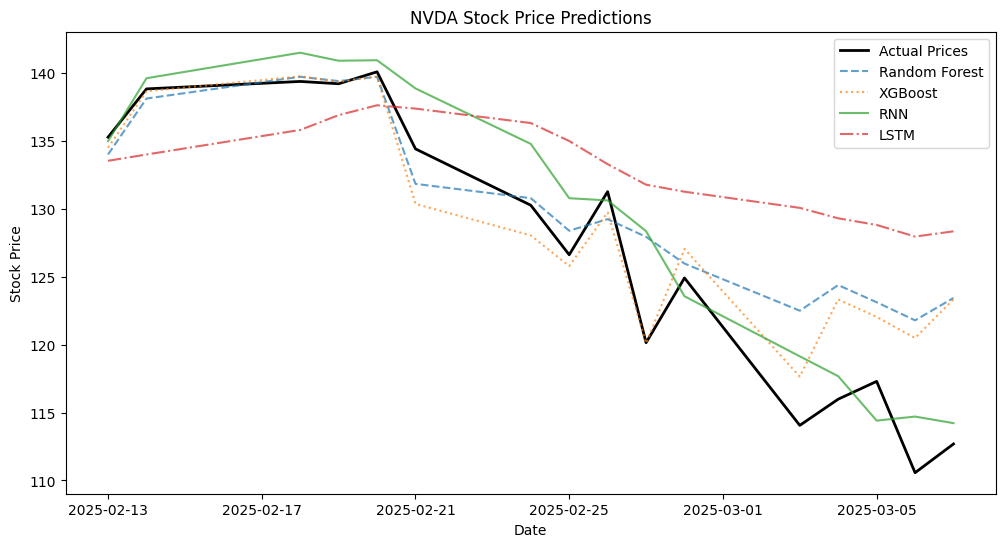

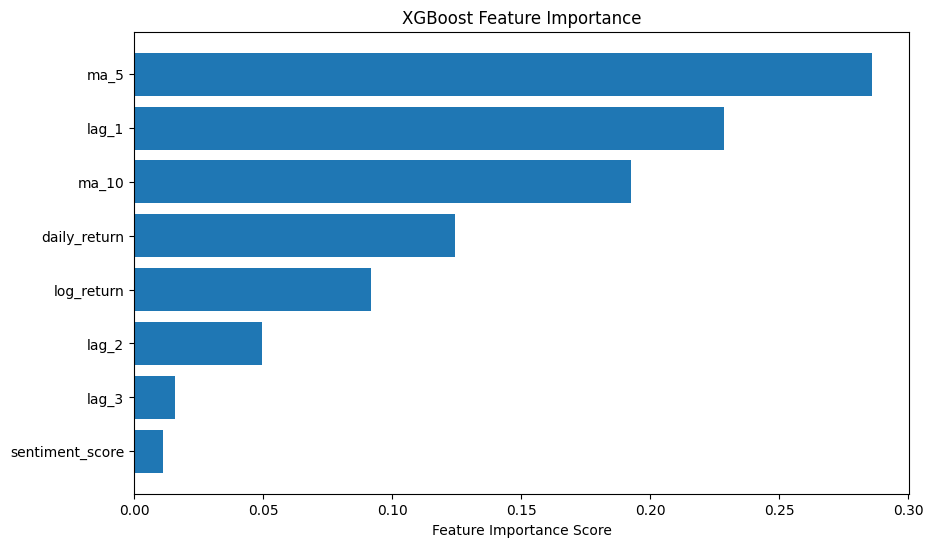

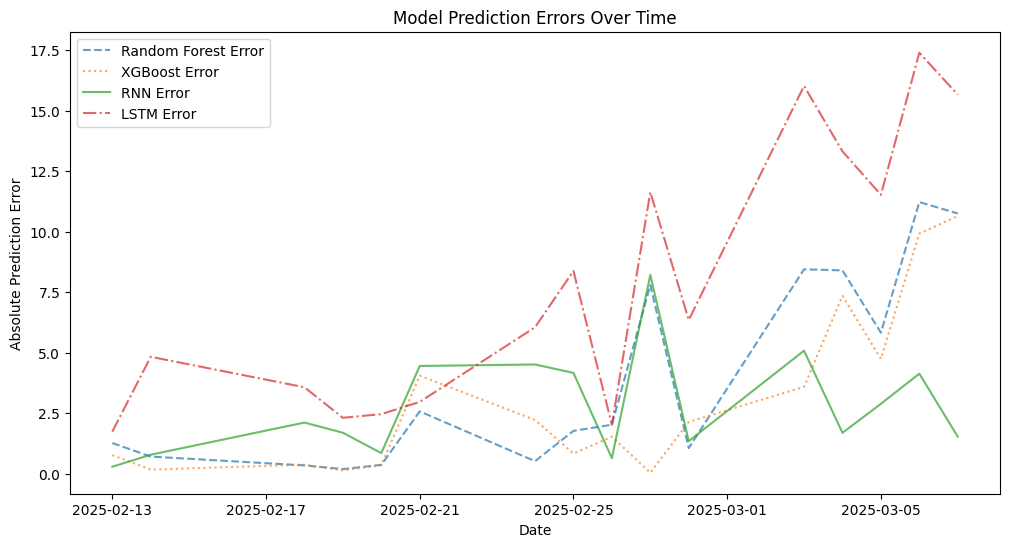

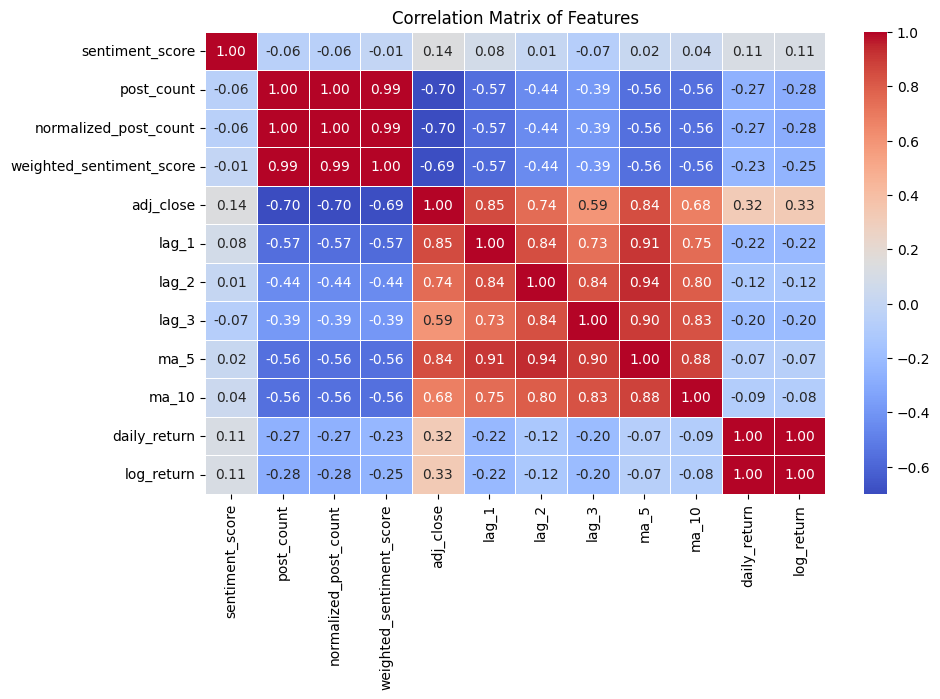

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load processed dataset
data = pd.read_csv("nvda_stock_sentiment_features.csv")
data["date_only"] = pd.to_datetime(data["date_only"])
data.set_index("date_only", inplace=True)

# Define Features and Target
features = ["sentiment_score", "lag_1", "lag_2", "lag_3", "ma_5", "ma_10", "daily_return", "log_return"]
X = data[features]
y = data["adj_close"]

# Train-Test Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature Scaling
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Target Scaling
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Reshape for RNN models
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Random Forest Model
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=4, min_samples_leaf=2, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)
rf_preds_scaled = rf.predict(X_test_scaled)
rf_preds = target_scaler.inverse_transform(rf_preds_scaled.reshape(-1, 1)).flatten()

# XGBoost Model
xgb = XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train_scaled, y_train_scaled)
xgb_preds_scaled = xgb.predict(X_test_scaled)
xgb_preds = target_scaler.inverse_transform(xgb_preds_scaled.reshape(-1, 1)).flatten()

# RNN Model
rnn_model = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.3),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rnn_model.fit(
    X_train_rnn, y_train_scaled,
    epochs=150,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)
rnn_preds_scaled = rnn_model.predict(X_test_rnn).flatten()
rnn_preds = target_scaler.inverse_transform(rnn_preds_scaled.reshape(-1, 1)).flatten()

# LSTM Model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

lstm_model.fit(
    X_train_rnn, y_train_scaled,
    epochs=200,
    batch_size=16,
    verbose=1,
    validation_split=0.2
)
lstm_preds_scaled = lstm_model.predict(X_test_rnn).flatten()
lstm_preds = target_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# Evaluate all Models
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f" {name} Performance:")
    print(f"   MAE: {mae:.4f}")
    print(f"   MSE: {mse:.4f}")
    print(f"   R² Score: {r2:.4f}")
    print("-" * 40)
    return mae, mse, r2

rf_metrics = evaluate_model("Random Forest", y_test, rf_preds)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_preds)
rnn_metrics = evaluate_model("RNN", y_test, rnn_preds)
lstm_metrics = evaluate_model("LSTM", y_test, lstm_preds)

# Plot Model Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Prices", color="black", linewidth=2)
plt.plot(y_test.index, rf_preds, label="Random Forest", linestyle="dashed", alpha=0.7)
plt.plot(y_test.index, xgb_preds, label="XGBoost", linestyle="dotted", alpha=0.7)
plt.plot(y_test.index, rnn_preds, label="RNN", linestyle="solid", alpha=0.7)
plt.plot(y_test.index, lstm_preds, label="LSTM", linestyle="dashdot", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("NVDA Stock Price Predictions")
plt.legend()
plt.show()

# Get feature importances from XGBoost
importances = xgb.feature_importances_
feature_names = X.columns

# Sort feature importances
sorted_idx = np.argsort(importances)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# Compute Absolute Prediction Errors
rf_errors = np.abs(y_test - rf_preds)
xgb_errors = np.abs(y_test - xgb_preds)
rnn_errors = np.abs(y_test - rnn_preds)
lstm_errors = np.abs(y_test - lstm_preds)

# Plot Prediction Errors Over Time
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, rf_errors, label="Random Forest Error", linestyle="dashed", alpha=0.7)
plt.plot(y_test.index, xgb_errors, label="XGBoost Error", linestyle="dotted", alpha=0.7)
plt.plot(y_test.index, rnn_errors, label="RNN Error", linestyle="solid", alpha=0.7)
plt.plot(y_test.index, lstm_errors, label="LSTM Error", linestyle="dashdot", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Absolute Prediction Error")
plt.title("Model Prediction Errors Over Time")
plt.legend()
plt.show()

# Compute Correlation Matrix
correlation_matrix = data.corr()

# Plot Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()